### UCL - Information Retrieval and Data Mining 2016

This demo trains a Convolutional Neural Network(CNN) on the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset with [TensorFlow](https://www.tensorflow.org/)


In [1]:
import cifar10_input # The input code refers to tensorflow source code
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import sys
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline 

In [2]:
# if the cifar-10 is not exist, then download and extract
cifar10_input.maybe_download_and_extract()
data_dir = os.path.join('./data/', 'cifar-10-batches-bin')


Successfully downloaded cifar-10-binary.tar.gz 170052171 bytes.


In [3]:
IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_CHANNELS = 3 # RGB channels
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
DROPOUT_KEEP_PROB = 0.5

num_batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / BATCH_SIZE
total_batch_step =  num_batches_per_epoch * NUM_EPOCHS


# layers' weight/filter & bias
W = {
    # 5x5 conv, 3 channels, 32 outputs
    'conv1_filters': tf.Variable(tf.random_normal([5, 5, NUM_CHANNELS, 32])), 
    # 5x5 conv, 32 inputs, 64 outputs
    'conv2_filters': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 8*8-1*64 inputs, 1024 outputs
    'local3_weight': tf.Variable(tf.random_normal([8 * 8 * 64, 1024])), 
    # 1024 inputs, 10 outputs 
    'softmax_linear_weight': tf.Variable(tf.random_normal([1024, NUM_CLASSES])) 
}
b = {
    'conv1_bias': tf.Variable(tf.random_normal([32])),
    'conv2_bias': tf.Variable(tf.random_normal([64])),
    'local3_bias': tf.Variable(tf.random_normal([1024])),
    'softmax_linear_bias': tf.Variable(tf.random_normal([NUM_CLASSES]))
}

Here is an CIFAR image example: we get a image(32x32x3 array of pixel values), then we pipe this image through the CNN netwrok and get softmaxt output with 10 numbers which means the probability of each class.

![cnn diagram](./cnn_diagram.jpg "CNN diagram")

In [4]:
class CNN(object):
    def __init__(self,images,X,Y,W,b,dropout_keep_prob):
        # both for demo visulization, not necessary for real training
        self.image = images
        self.x = X
        
        # Convolution Layer 1 with 32 5X5 filters and ReLU activation
        with tf.variable_scope('conv1'):
            conv = tf.nn.conv2d(X, W['conv1_filters'], [1, 1, 1, 1], padding='SAME')
            bias = tf.nn.bias_add(conv, b['conv1_bias'])
            self.conv1 = tf.nn.relu(bias, name='conv1')
        # max-pooling layer 1 with 3X3 window size and 2X2 stride
        self.pool1 = tf.nn.max_pool(self.conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

        # Convolution Layer 2 with 64 5X5 filters and ReLU activation
        with tf.variable_scope('conv2'):
            conv = tf.nn.conv2d(self.pool1, W['conv2_filters'], [1, 1, 1, 1], padding='SAME')
            bias = tf.nn.bias_add(conv, b['conv2_bias'])
            self.conv2 = tf.nn.relu(bias, name='conv2')
        # max-pooling layer 2 with 3X3 window size and 2X2 stride
        self.pool2 = tf.nn.max_pool(self.conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')

        # Move everything into depth so we can perform a single matrix multiply.
        reshape = tf.reshape(self.pool2, [-1, 8 * 8 * 64])

        # Apply the dropout
        with tf.variable_scope('dropout'):
            dropped = tf.nn.dropout(reshape, dropout_keep_prob)

        # fully connected
        with tf.variable_scope('local3') as scope:
            self.local3 = tf.nn.relu(tf.matmul(dropped, W['local3_weight']) + b['local3_bias'], name='local3')

        # softmax, softmax(WX + b)
        with tf.variable_scope('softmax_linear'):
            softmax_linear = tf.add(tf.matmul(self.local3, W['softmax_linear_weight']), b['softmax_linear_bias'], 
                                    name='softmax_linear')
        
        # caculate the loss
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(softmax_linear, tf.cast(Y,'float')))
        
        # output and caculate accuracy
        with tf.variable_scope('accuracy'):  
            correct_prediction = tf.equal(tf.argmax(softmax_linear,1), tf.argmax(Y,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [5]:
def visulization(img,norm_img,pool1,pool2):
    plt.figure(figsize=(15, 10))
    plt.subplot(3,4,1)
    # plot the first original image in this batch
    plt.imshow(img[0,:,:,:]/255)
    plt.title("original image")
    plt.subplot(3,4,2)
    # plot the first 
    plt.imshow(norm_img[0,:,:,:])
    plt.title("distorted and normalized image")
    # plot the first four conv1 activations of first sample in this batch
    for i in range(4):
        activation = pool1[0,:,:,i]
        plt.subplot(3,4,i+5)
        plt.imshow(activation, 
                   interpolation="none",
                   cmap=plt.get_cmap("gray"))
        plt.title("conv1 activation " + str(i+1))
    # plot the first four conv2 activations of first sample in this batch
    for i in range(4):
        activation = pool2[0,:,:,i]
        plt.subplot(3,4,i+9)
        plt.imshow(activation, 
                   interpolation="none",
                   cmap=plt.get_cmap("gray"))
        plt.title("conv2 activation " + str(i+1))
    plt.show()

In [6]:
def train():
    with tf.device('/cpu:0'):
        # start a tensorflow runing session
        sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        global_step = tf.Variable(0, name="global_step", trainable=False)
        
        # get inputs for CIFAR training
        # the images are original image and used for visulization.
        # normalized_images are used to train the model, and have gone through following prcoesses:
        #    1. Randomly crop a [height, width] section of the image.
        #    2. Randomly flip the image horizontally.
        #    3. Randomly adjust the constract and brightness of the image.
        #    4. Normalization: subtract off the mean and divide by the variance of the pixels.
        # details can be found in cifar10_input
        images, normalized_images, labels = cifar10_input.distorted_inputs(data_dir=data_dir, batch_size=BATCH_SIZE)
        
        cnn = CNN(images,normalized_images,labels,W,b,DROPOUT_KEEP_PROB)
        
        # use adam optimizer (adaptive SGD) to update parameters
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
        # compute the gradients for parameters
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        # update the parameters with gradients
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        init = tf.initialize_all_variables()
        sess.run(init)
        # Start the queue runners.
        tf.train.start_queue_runners(sess=sess)
        print("Begin Trainig")
        DEMO_MODE = True # turn demo mode on to show visulization
        for current_step in xrange(total_batch_step):
            # run a batch
            _,loss_value, acc, pool1, pool2, img, norm_img = sess.run([train_op, cnn.loss, cnn.accuracy, cnn.pool1, cnn.pool2, cnn.image, cnn.x])
            
            time_str = datetime.datetime.now().isoformat()
            if DEMO_MODE == True:
                # clear current output on the screen
                clear_output()
                # display and print the training process
                print("Training --- {}: step {}, loss {:g}, acc {:g}".format(time_str, current_step, loss_value, acc))
                visulization(img,norm_img,pool1,pool2)
                if current_step == 20:
                    break
            else:
                # print the training process every 100 steps
                if current_step % 100 == 0:
                    print("Training --- {}: step {}, loss {:g}, acc {:g}".format(time_str, current_step, loss_value, acc))

Training --- 2016-03-10T17:39:04.189256: step 20, loss 296063, acc 0.15625


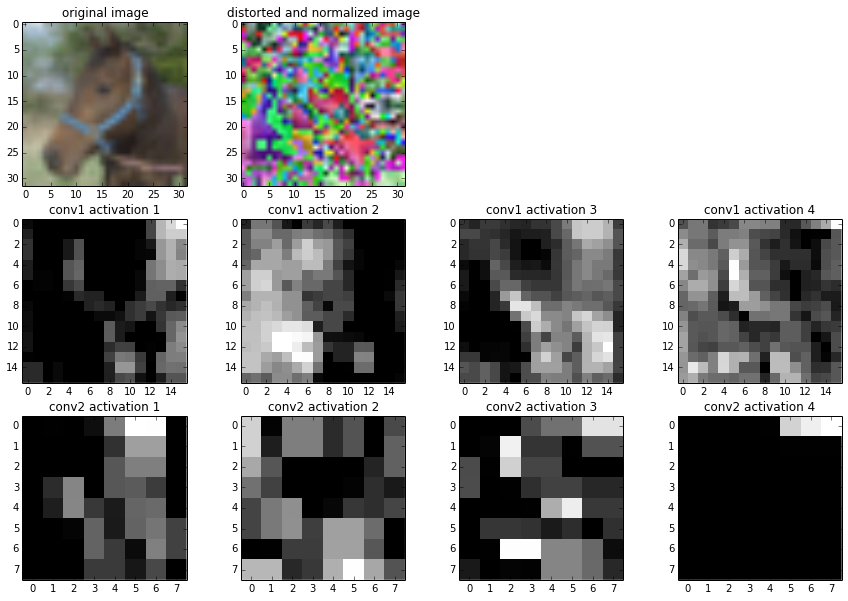

Done


In [7]:
# start to train the model
train()
print("Done")